[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rodrigobdz/neural-processes/blob/main/neural-processes.ipynb)

In [1]:
# Upload all .py files in neural_processes folder
# i.e. data_generator.py, decoder.py, encoder.py, mlp.py, model.py, and utils.py
from google.colab import files
uploaded = files.upload()

Saving __init__.py to __init__.py
Saving data_generator.py to data_generator.py
Saving decoder.py to decoder.py
Saving encoder.py to encoder.py
Saving mlp.py to mlp.py
Saving mnist.py to mnist.py
Saving model.py to model.py
Saving plot.py to plot.py
Saving utils.py to utils.py


In [2]:
# Place uploaded files in neural_processes folder to mimic folder structure in repo
!rm -rf sample_data/
!mkdir -p neural_processes
!mv *.py neural_processes/

In [3]:
import neural_processes

In [4]:
import matplotlib.pyplot as plt

import torch
from torch import distributions
from torch import nn 
from torch import optim

import torchvision
from torchvision import datasets

In [5]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda')

In [6]:
TRAINING_ITERATIONS = 100000 #@param {type:"number"}
MAX_NUM_CONTEXT = 50 #@param {type:"number"}
PLOT_AFTER = 10000 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}

random_kernel_parameters=True #@param {type:"boolean"}

batch_size = 16
max_num_context = MAX_NUM_CONTEXT
x_size = 1
y_size = 1
length_scale = 0.6
sigma_scale = 1.0
num_iter = TRAINING_ITERATIONS
save_iter = PLOT_AFTER

In [7]:
gp = neural_processes.data_generator.GPCurves(batch_size, max_num_context, x_size, y_size, length_scale, sigma_scale, dev='cuda')
train_list = [gp.generate_curves() for _ in range(num_iter)]

KeyboardInterrupt: ignored

In [8]:
batch_size = 1
gptest = neural_processes.data_generator.GPCurves(batch_size, max_num_context, testing=True, dev='cuda')
test_list = [gptest.generate_curves()]

In [9]:
in_features = 1 
h_size = HIDDEN_SIZE
encoder_out = [128, 256, 512, 1024] # [h_size]*4
decoder_out = [512, 256] + [2] # [128]*2 + [2] 
mc_size = 1

In [11]:
np = neural_processes.model.NeuralProcess(in_features, encoder_out, decoder_out, h_size, mc_size)
np.to(dev)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1024, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=128, out_features=128, bias=True)
    (_log_sigma): Linear(in_features=128, out_features=128, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=129, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

In [8]:
# Xavier_Uniform weight init
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

np.apply(init_weights)

NameError: ignored

Iteration: 0, loss: 27.930179595947266


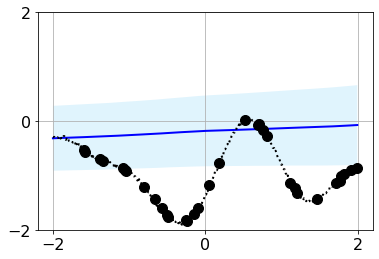

Iteration: 10000, loss: 25.39400863647461


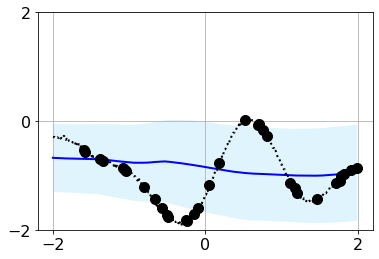

Iteration: 20000, loss: 8.885335922241211


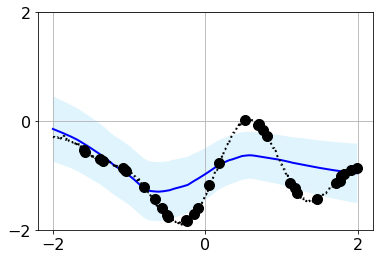

Iteration: 30000, loss: 3.867004871368408


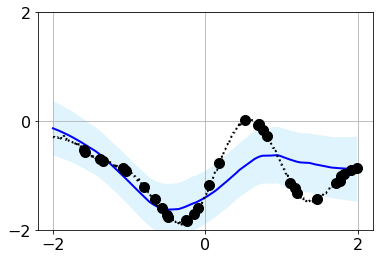

Iteration: 40000, loss: -1.9484446048736572


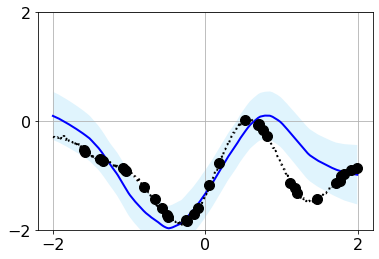

Iteration: 50000, loss: -0.43121814727783203


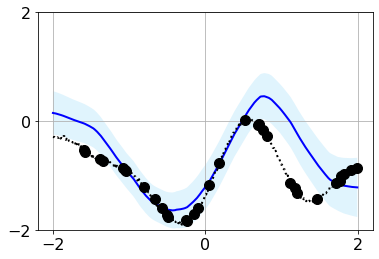

Iteration: 60000, loss: -2.0161499977111816


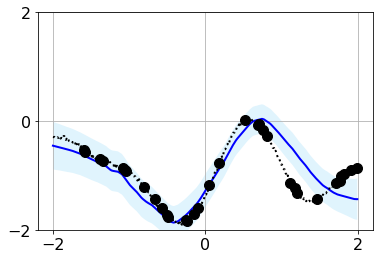

Iteration: 70000, loss: -10.818398475646973


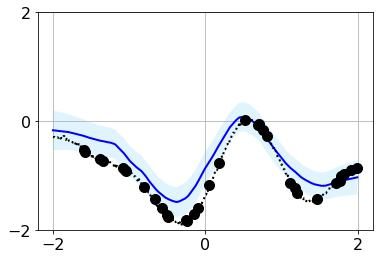

Iteration: 80000, loss: 1.3421375751495361


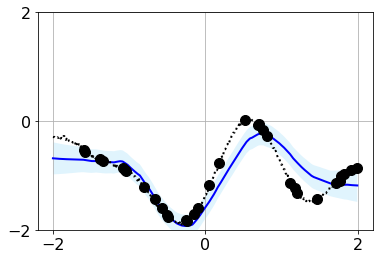

Iteration: 90000, loss: -3.6306228637695312


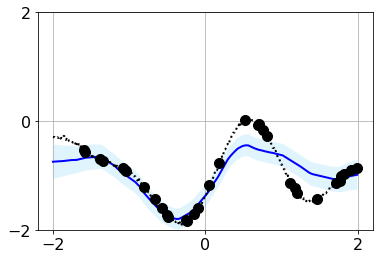

In [13]:
mu, sigma = np.fit(num_iter, save_iter, train_list, test_list)

# Save Neural Process model to Google Drive
Uncomment the code in the following cell to enable this.

In [14]:
# Mount drive
# Source: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
# from google.colab import drive
# drive.mount('/content/gdrive')

# Save model
# Source: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# !mkdir -p /content/gdrive/MyDrive/neural-processes-model
# torch.save(np, '/content/gdrive/MyDrive/neural-processes-model.pt')

In [10]:
# Hotfix for missing HTTP headers in pytorch's HTTP request for MNIST dataset download
# Source:
# https://github.com/pytorch/vision/issues/1938#issuecomment-594623431
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [11]:
# ToTensor() maps to range [0, 1]
train_mnist = datasets.MNIST('./data', download=True, transform=torchvision.transforms.ToTensor()) 
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [12]:
if dev.type == 'cuda':
  pin_memory = True
else:
  pin_memory = False

params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory': pin_memory}
          
train_generator = torch.utils.data.DataLoader(train_mnist, **params)

In [13]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 4,
          'pin_memory': pin_memory}
          
test_generator = torch.utils.data.DataLoader(test_mnist, **params)

In [14]:
in_features = 2 
h_size = 256
encoder_out = [h_size] # [128, 256, 512, 1024] 
decoder_out = [h_size] + [2] # [512, 256] + [2] 
mc_size = 1

In [15]:
np = neural_processes.model.NeuralProcess(in_features, encoder_out, decoder_out, h_size, mc_size)
np.to(dev)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=3, out_features=256, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=256, out_features=256, bias=True)
    (_log_sigma): Linear(in_features=256, out_features=256, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=258, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

In [16]:
opt = optim.Adam(np.parameters(), lr=5e-5) 

Epoch: 0, Iteration: 0, loss: 109.31525421142578
Epoch: 0, Iteration: 1000, loss: 65.05448913574219
Epoch: 0, Iteration: 2000, loss: 16.700931549072266
Epoch: 0, Iteration: 3000, loss: 84.0899658203125
Iteration: 3749, loss: 54.29644012451172
241
783


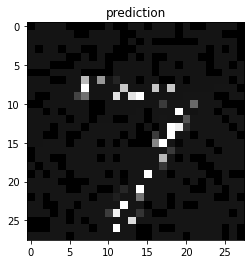

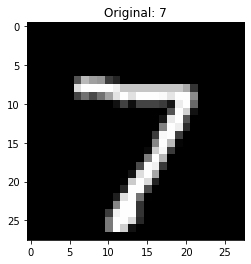

Epoch: 1, Iteration: 0, loss: 54.58955764770508
Epoch: 1, Iteration: 1000, loss: 61.43389129638672
Epoch: 1, Iteration: 2000, loss: 95.43151092529297
Epoch: 1, Iteration: 3000, loss: 82.15559387207031
Epoch: 2, Iteration: 0, loss: 58.61069869995117
Epoch: 2, Iteration: 1000, loss: 70.16923522949219
Epoch: 2, Iteration: 2000, loss: 3.2892165184020996
Epoch: 2, Iteration: 3000, loss: 72.13987731933594
Epoch: 3, Iteration: 0, loss: 49.27838134765625
Epoch: 3, Iteration: 1000, loss: 61.47029495239258
Epoch: 3, Iteration: 2000, loss: 64.288818359375
Epoch: 3, Iteration: 3000, loss: 50.10687255859375
Epoch: 4, Iteration: 0, loss: 40.7549934387207
Epoch: 4, Iteration: 1000, loss: 64.98822784423828
Epoch: 4, Iteration: 2000, loss: 113.43086242675781
Epoch: 4, Iteration: 3000, loss: 24.263883590698242
Epoch: 5, Iteration: 0, loss: 83.60137939453125
Epoch: 5, Iteration: 1000, loss: 68.91276550292969
Epoch: 5, Iteration: 2000, loss: 64.30467987060547
Epoch: 5, Iteration: 3000, loss: 66.1263122558

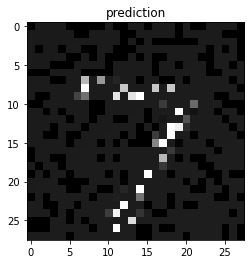

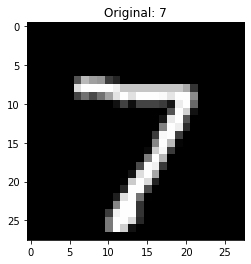

Epoch: 6, Iteration: 0, loss: 54.72581100463867
Epoch: 6, Iteration: 1000, loss: 73.18938446044922
Epoch: 6, Iteration: 2000, loss: 76.99697875976562
Epoch: 6, Iteration: 3000, loss: 52.15064239501953
Epoch: 7, Iteration: 0, loss: 72.37786102294922
Epoch: 7, Iteration: 1000, loss: 70.750732421875
Epoch: 7, Iteration: 2000, loss: 43.97400665283203
Epoch: 7, Iteration: 3000, loss: 85.64117431640625
Epoch: 8, Iteration: 0, loss: 86.78739166259766
Epoch: 8, Iteration: 1000, loss: 44.89179229736328
Epoch: 8, Iteration: 2000, loss: 100.78279113769531
Epoch: 8, Iteration: 3000, loss: 35.52851104736328
Epoch: 9, Iteration: 0, loss: 76.74237823486328
Epoch: 9, Iteration: 1000, loss: 52.85476303100586
Epoch: 9, Iteration: 2000, loss: 103.74095153808594
Epoch: 9, Iteration: 3000, loss: 28.91974639892578
Epoch: 10, Iteration: 0, loss: 97.29743194580078
Epoch: 10, Iteration: 1000, loss: 68.24790954589844
Epoch: 10, Iteration: 2000, loss: 63.09927749633789
Epoch: 10, Iteration: 3000, loss: 52.297725

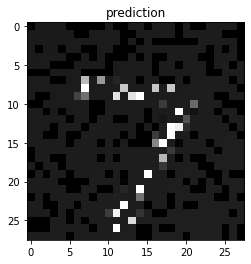

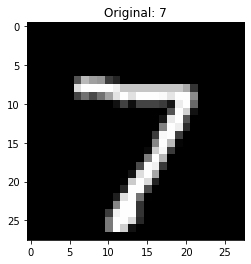

Epoch: 11, Iteration: 0, loss: 82.27935028076172
Epoch: 11, Iteration: 1000, loss: 83.08045959472656
Epoch: 11, Iteration: 2000, loss: 116.89096069335938
Epoch: 11, Iteration: 3000, loss: 95.87985229492188
Epoch: 12, Iteration: 0, loss: 66.86880493164062
Epoch: 12, Iteration: 1000, loss: 99.38179016113281
Epoch: 12, Iteration: 2000, loss: 71.3990707397461
Epoch: 12, Iteration: 3000, loss: 63.12803649902344
Epoch: 13, Iteration: 0, loss: 76.35626220703125
Epoch: 13, Iteration: 1000, loss: 71.61131286621094
Epoch: 13, Iteration: 2000, loss: 77.31390380859375
Epoch: 13, Iteration: 3000, loss: 66.42648315429688
Epoch: 14, Iteration: 0, loss: 99.31460571289062
Epoch: 14, Iteration: 1000, loss: 68.06916046142578
Epoch: 14, Iteration: 2000, loss: 89.36770629882812
Epoch: 14, Iteration: 3000, loss: 15.617420196533203
Epoch: 15, Iteration: 0, loss: 75.50785827636719
Epoch: 15, Iteration: 1000, loss: 79.26754760742188
Epoch: 15, Iteration: 2000, loss: 65.2069320678711
Epoch: 15, Iteration: 3000,

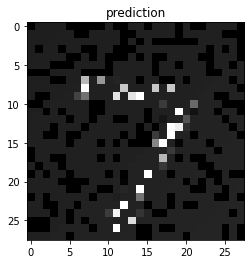

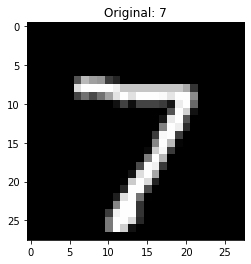

Epoch: 16, Iteration: 0, loss: 62.12015914916992
Epoch: 16, Iteration: 1000, loss: 102.01896667480469
Epoch: 16, Iteration: 2000, loss: 24.199600219726562
Epoch: 16, Iteration: 3000, loss: 21.784591674804688
Epoch: 17, Iteration: 0, loss: 45.12274932861328
Epoch: 17, Iteration: 1000, loss: 52.25422668457031
Epoch: 17, Iteration: 2000, loss: 74.74578857421875
Epoch: 17, Iteration: 3000, loss: 64.50080871582031
Epoch: 18, Iteration: 0, loss: 80.79226684570312
Epoch: 18, Iteration: 1000, loss: 43.433380126953125
Epoch: 18, Iteration: 2000, loss: 57.53388214111328
Epoch: 18, Iteration: 3000, loss: 36.333587646484375
Epoch: 19, Iteration: 0, loss: 115.9186782836914
Epoch: 19, Iteration: 1000, loss: 69.74180603027344
Epoch: 19, Iteration: 2000, loss: 72.95234680175781
Epoch: 19, Iteration: 3000, loss: 70.96671295166016
Epoch: 20, Iteration: 0, loss: 67.30347442626953
Epoch: 20, Iteration: 1000, loss: 11.840368270874023
Epoch: 20, Iteration: 2000, loss: 56.69295120239258
Epoch: 20, Iteration:

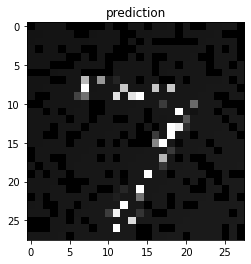

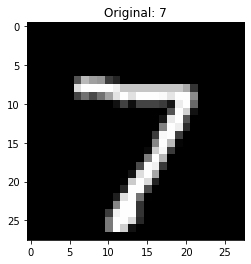

Epoch: 21, Iteration: 0, loss: 47.108299255371094
Epoch: 21, Iteration: 1000, loss: 51.33772659301758
Epoch: 21, Iteration: 2000, loss: 33.92209243774414
Epoch: 21, Iteration: 3000, loss: 62.9722900390625
Epoch: 22, Iteration: 0, loss: 75.04339599609375
Epoch: 22, Iteration: 1000, loss: 30.65320587158203
Epoch: 22, Iteration: 2000, loss: 40.18750762939453
Epoch: 22, Iteration: 3000, loss: 22.81427764892578
Epoch: 23, Iteration: 0, loss: 79.71829223632812
Epoch: 23, Iteration: 1000, loss: 25.419845581054688
Epoch: 23, Iteration: 2000, loss: 53.59400939941406
Epoch: 23, Iteration: 3000, loss: 32.347633361816406
Epoch: 24, Iteration: 0, loss: 70.30498504638672
Epoch: 24, Iteration: 1000, loss: 69.13432312011719
Epoch: 24, Iteration: 2000, loss: 55.57374954223633
Epoch: 24, Iteration: 3000, loss: 48.281341552734375
Epoch: 25, Iteration: 0, loss: 53.701866149902344
Epoch: 25, Iteration: 1000, loss: 46.35489273071289
Epoch: 25, Iteration: 2000, loss: 64.08085632324219
Epoch: 25, Iteration: 3

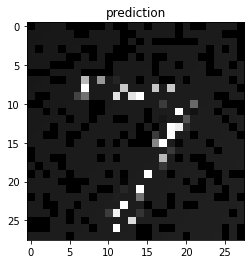

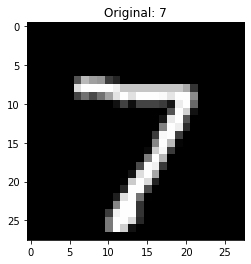

Epoch: 26, Iteration: 0, loss: 63.78865432739258
Epoch: 26, Iteration: 1000, loss: 61.445701599121094
Epoch: 26, Iteration: 2000, loss: 40.84637451171875
Epoch: 26, Iteration: 3000, loss: 92.9661636352539
Epoch: 27, Iteration: 0, loss: 63.31585693359375
Epoch: 27, Iteration: 1000, loss: 47.38983154296875
Epoch: 27, Iteration: 2000, loss: 56.004642486572266
Epoch: 27, Iteration: 3000, loss: 81.77672576904297
Epoch: 28, Iteration: 0, loss: 27.896305084228516
Epoch: 28, Iteration: 1000, loss: 91.9887466430664
Epoch: 28, Iteration: 2000, loss: 74.140869140625
Epoch: 28, Iteration: 3000, loss: 72.14610290527344
Epoch: 29, Iteration: 0, loss: 61.43299865722656
Epoch: 29, Iteration: 1000, loss: 69.58722686767578
Epoch: 29, Iteration: 2000, loss: 95.96965026855469
Epoch: 29, Iteration: 3000, loss: 67.52896118164062
Epoch: 30, Iteration: 0, loss: 75.89006042480469
Epoch: 30, Iteration: 1000, loss: 78.20459747314453
Epoch: 30, Iteration: 2000, loss: 40.89807891845703
Epoch: 30, Iteration: 3000, 

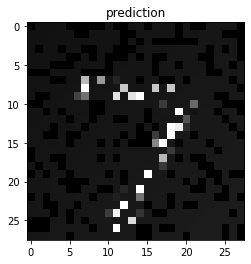

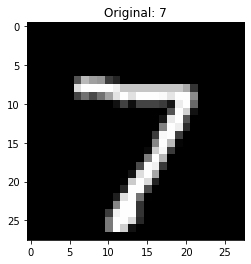

Epoch: 31, Iteration: 0, loss: 71.01934051513672
Epoch: 31, Iteration: 1000, loss: 101.30120849609375
Epoch: 31, Iteration: 2000, loss: 47.05897903442383
Epoch: 31, Iteration: 3000, loss: 73.72328186035156
Epoch: 32, Iteration: 0, loss: 51.11341857910156
Epoch: 32, Iteration: 1000, loss: 37.06229782104492
Epoch: 32, Iteration: 2000, loss: 58.87605285644531
Epoch: 32, Iteration: 3000, loss: 47.65528106689453
Epoch: 33, Iteration: 0, loss: 61.65988540649414
Epoch: 33, Iteration: 1000, loss: 40.807594299316406
Epoch: 33, Iteration: 2000, loss: 81.25237274169922
Epoch: 33, Iteration: 3000, loss: 66.36421203613281
Epoch: 34, Iteration: 0, loss: 69.62124633789062
Epoch: 34, Iteration: 1000, loss: 67.9074935913086
Epoch: 34, Iteration: 2000, loss: 89.23345947265625
Epoch: 34, Iteration: 3000, loss: 59.83427810668945
Epoch: 35, Iteration: 0, loss: 41.51514434814453
Epoch: 35, Iteration: 1000, loss: 51.06812286376953
Epoch: 35, Iteration: 2000, loss: 84.91348266601562
Epoch: 35, Iteration: 3000

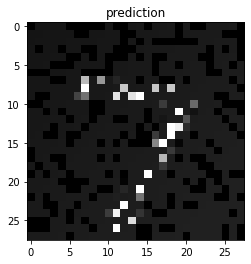

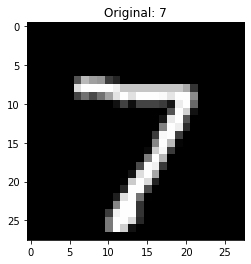

Epoch: 36, Iteration: 0, loss: 60.09169006347656
Epoch: 36, Iteration: 1000, loss: 89.47075653076172
Epoch: 36, Iteration: 2000, loss: 93.13554382324219
Epoch: 36, Iteration: 3000, loss: 83.60603332519531
Epoch: 37, Iteration: 0, loss: 49.1625862121582
Epoch: 37, Iteration: 1000, loss: 64.18814086914062
Epoch: 37, Iteration: 2000, loss: 40.52960968017578
Epoch: 37, Iteration: 3000, loss: 9.68198013305664
Epoch: 38, Iteration: 0, loss: 68.46884155273438
Epoch: 38, Iteration: 1000, loss: 35.748050689697266
Epoch: 38, Iteration: 2000, loss: 83.74777221679688
Epoch: 38, Iteration: 3000, loss: 112.58021545410156
Epoch: 39, Iteration: 0, loss: 42.091609954833984
Epoch: 39, Iteration: 1000, loss: 30.464996337890625
Epoch: 39, Iteration: 2000, loss: 25.302974700927734
Epoch: 39, Iteration: 3000, loss: 50.54482650756836
Epoch: 40, Iteration: 0, loss: 60.06061553955078
Epoch: 40, Iteration: 1000, loss: 82.88423156738281
Epoch: 40, Iteration: 2000, loss: 89.05908203125
Epoch: 40, Iteration: 3000,

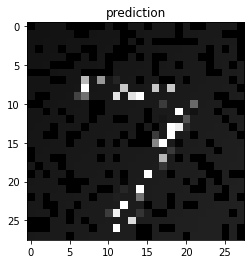

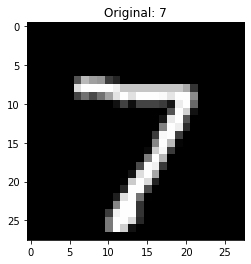

Epoch: 41, Iteration: 0, loss: 67.1124267578125
Epoch: 41, Iteration: 1000, loss: 60.9547004699707
Epoch: 41, Iteration: 2000, loss: 92.86888885498047
Epoch: 41, Iteration: 3000, loss: 52.16204071044922
Epoch: 42, Iteration: 0, loss: 44.60065841674805
Epoch: 42, Iteration: 1000, loss: 98.19088745117188
Epoch: 42, Iteration: 2000, loss: 87.32352447509766
Epoch: 42, Iteration: 3000, loss: 74.98776245117188
Epoch: 43, Iteration: 0, loss: 63.50927734375
Epoch: 43, Iteration: 1000, loss: 97.05020141601562
Epoch: 43, Iteration: 2000, loss: 16.393686294555664
Epoch: 43, Iteration: 3000, loss: 64.85990905761719
Epoch: 44, Iteration: 0, loss: 57.27446746826172
Epoch: 44, Iteration: 1000, loss: 49.851661682128906
Epoch: 44, Iteration: 2000, loss: 50.93560791015625
Epoch: 44, Iteration: 3000, loss: 114.78414916992188
Epoch: 45, Iteration: 0, loss: 78.72230529785156
Epoch: 45, Iteration: 1000, loss: 77.69886016845703
Epoch: 45, Iteration: 2000, loss: 74.63341522216797
Epoch: 45, Iteration: 3000, l

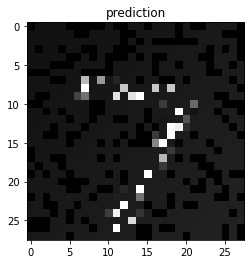

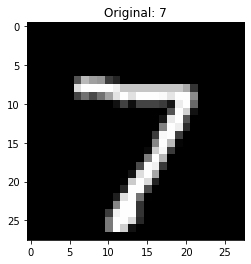

Epoch: 46, Iteration: 0, loss: 55.90620422363281
Epoch: 46, Iteration: 1000, loss: 50.45137023925781
Epoch: 46, Iteration: 2000, loss: 21.413909912109375
Epoch: 46, Iteration: 3000, loss: 77.10757446289062
Epoch: 47, Iteration: 0, loss: 34.639373779296875
Epoch: 47, Iteration: 1000, loss: 62.710716247558594
Epoch: 47, Iteration: 2000, loss: 70.94486999511719
Epoch: 47, Iteration: 3000, loss: 77.16615295410156
Epoch: 48, Iteration: 0, loss: 18.9650936126709
Epoch: 48, Iteration: 1000, loss: 70.54817962646484
Epoch: 48, Iteration: 2000, loss: 72.78592681884766
Epoch: 48, Iteration: 3000, loss: 75.1491470336914
Epoch: 49, Iteration: 0, loss: 53.34308624267578
Epoch: 49, Iteration: 1000, loss: 70.30775451660156
Epoch: 49, Iteration: 2000, loss: 24.23307991027832
Epoch: 49, Iteration: 3000, loss: 7.334323883056641


In [17]:
epochs = 50
save_epoch = 5
num_iter = 60000 // 16
# mu, sigma = fit_mnist(epochs, num_iter, save_epoch, np, opt, train_generator, test_generator, dev)
mu, sigma = neural_processes.mnist.fit_mnist2(epochs, 
                                              save_epoch,
                                              np, opt, 
                                              train_generator, 
                                              test_generator, 
                                              dev)

In [ ]:
# TODO overfitting 3 classes, avg. epoch loss

In [ ]:
test_set = preprocess_mnist(test_generator, dev, train=False)

In [ ]:
xc, yc, xt, yt = test_set[6]

In [ ]:
m = torch.zeros(28, 28)
x, y = rescale(xt[0], mu.detach()[0], 'cpu')
xk, yk = rescale(xc[0], yc[0], 'cpu')

num_context = xk.shape[0]

for i, val in enumerate(x):
    
    if i < num_context:
      m[val[0], val[1]] = yk[i]
    else:
      m[val[0], val[1]] = y[i]

plt.imshow(m)